S-FCI Algorithm for Structure Learning on Simulated Data
========================================================

The SFCI algorithm is shown to be a generalization of the FCI, I-FCI and $\Psi$-FCI algorithms, which is
capable of structure learning over observational and/or interventional data collected across multiple
environments.

In this example, we will leverage [pywhy_graphs](simulation_example) to simulate a discrete causal Bayesian
network, which acts as our causal selection diagram. We will also simulate different interventions and environments
to demonstrate how additional data that arises from different domains are useful.

In [1]:
%load_ext autoreload
%autoreload 2

In [220]:
from pprint import pprint

import bnlearn
import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats
from pywhy_graphs.functional import sample_from_graph
from pywhy_graphs.functional.discrete import (
    apply_discrete_soft_intervention,
    make_random_discrete_graph,
)
from pywhy_graphs.viz import draw

from dodiscover import (
    FCI,
    PC,
    SFCI,
    Context,
    InterventionalContextBuilder,
    PsiFCI,
    make_context,
)
from dodiscover.ci import CategoricalCITest, GSquareCITest, Oracle

In [4]:
from pgmpy.factors.discrete import JointProbabilityDistribution
from pgmpy.factors.discrete.CPD import TabularCPD


def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

In [5]:
n_jobs = -1

Draw a graph
------------


In [161]:
edge_list = [
    ("A", "B"),
    ("B", "C"),
    ("C", "D"),
    ("B", "D"),
    ("X", "A"),
    ("X", "C"),
    ("C", "W"),
]
G = nx.DiGraph()

G.add_edges_from(edge_list)

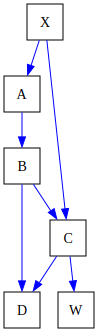

In [164]:
dot_graph = draw(G)
dot_graph.render(outfile="true_graph.png", view=False, cleanup=True)

dot_graph

Define the distributions for nodes and functions for edges
----------------------------------------------------------

Now, we can parametrize the graph fully, so that sampling from it is possible.

In [340]:
cardinality_lims = {node: [2, 4] for node in G.nodes}
weight_lims = {node: [1, 100] for node in G.nodes}
noise_ratio_lims = {node: [0.1, 0.1] for node in G.nodes}
seed = 1234

In [341]:
G = make_random_discrete_graph(
    G,
    cardinality_lims=cardinality_lims,
    weight_lims=weight_lims,
    noise_ratio_lims=noise_ratio_lims,
    random_state=seed,
    overwrite=True,
)

obs_G = G.copy()
print(G)

DiGraph with 6 nodes and 7 edges


In [342]:
# we can extract the conditional probability table for each node, which is a function of its parents
node_dict = G.nodes["C"]

print_full(node_dict["cpd"].cardinality)

[3 3 3]


In [343]:
# now we sample from the graph the discrete dataset
df = sample_from_graph(G, n_samples=40000, n_jobs=1, random_state=seed)

  0%|          | 0/6 [00:00<?, ?it/s]

In [122]:
display(df.head())
print(df.shape)

,A,B,C,D,W,X
0,2,1,0,0,2,1
1,1,1,2,1,2,2
2,1,2,2,2,0,1
3,1,1,2,2,1,2
4,1,2,2,1,1,2


(40000, 6)


Causal discovery: Observational data in a single domain
-------------------------------------------------------

First, we demonstrate how SFCI is exactly the same as the FCI algorithm in the context of single-domain observational data.

In [123]:
ci_estimator = CategoricalCITest(lambda_="cressie-read")

In [124]:
context = make_context().variables(data=df).build()

learner = SFCI(
    ci_estimator=ci_estimator,
    cd_estimator=ci_estimator,
    n_jobs=n_jobs,
    max_cond_set_size=2,
    max_combinations=None,
    # alpha=0.5,
)

In [125]:
learner.fit([df], context, domain_indices=[1], intervention_targets=[None])

Using data from distribution  0  for learning the skeleton.


In [126]:
# now let's run FCI
fci_learner = FCI(
    ci_estimator=ci_estimator,
    n_jobs=n_jobs,
    max_cond_set_size=2,
    max_combinations=None,
    # alpha=0.5,
)
fci_learner.fit(df, context)

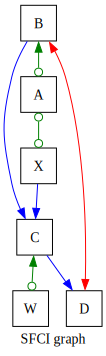

In [127]:
graph = learner.graph_
draw(graph, name="SFCI graph")

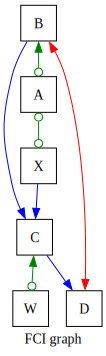

In [128]:
graph = fci_learner.graph_
draw(graph, name="FCI graph")

We see that both graphs are exactly the same, as we have shown theoretically, the SFCI algorithm is a generalization
of the FCI algorithm. Moreover, the S-PAG is a valid generalization of the PAG, and in this case, both graphs align perfectly.

Causal Discovery: Interventional data in a single domain
--------------------------------------------------------

Now, when we add interventional distributions, we expect that there will be additional
edges that we can orient due to the extra information when comparing different distributions.

In [147]:
rng = np.random.default_rng(seed)

In [148]:
# we will now simulate a set of interventions on the graph
targets = [
    ["X"],
    ["C"],
    ["D"],
]
data = [df]

for target in targets:
    int_G = apply_discrete_soft_intervention(G.copy(), target, random_state=seed)

    # now we sample from the graph the discrete dataset
    int_df = sample_from_graph(int_G, n_samples=30000, n_jobs=1, random_state=seed)

    data.append(int_df)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [156]:
print(len(data))

4


In [157]:
# create context with information about the interventions
ctx_builder = make_context(create_using=InterventionalContextBuilder)
ctx: Context = (
    ctx_builder.variables(data=data[0]).num_distributions(len(data))
    # .obs_distribution(True)
    .build()
)

In [132]:
int_learner = PsiFCI(
    ci_estimator=ci_estimator,
    cd_estimator=ci_estimator,
    max_cond_set_size=2,
    n_jobs=-1,
)

int_learner = int_learner.fit(data, ctx)

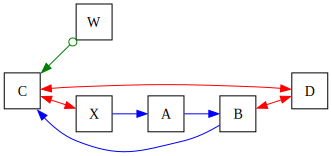

In [134]:
est_pag = int_learner.graph_.subgraph(ctx.get_non_augmented_nodes())

# %%
# Visualize the full graph including the F-node
draw(est_pag, direction="LR")

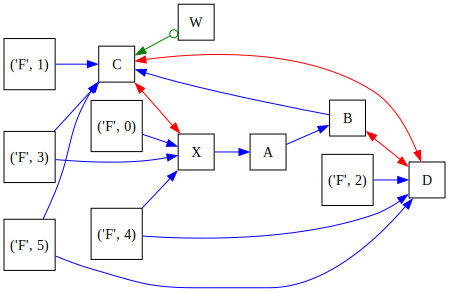

In [135]:
est_pag = int_learner.graph_

# %%
# Visualize the full graph including the F-node
draw(est_pag, direction="LR")

In [150]:
intervention_targets = targets.copy()
intervention_targets.insert(0, None)
print(intervention_targets)

[None, ['X'], ['C'], ['D']]


In [141]:
learner = SFCI(
    ci_estimator=ci_estimator,
    cd_estimator=ci_estimator,
    max_cond_set_size=2,
    n_jobs=-1,
)

learner.fit(
    data,
    ctx,
    domain_indices=[1, 1, 1, 1],
    intervention_targets=intervention_targets,
)

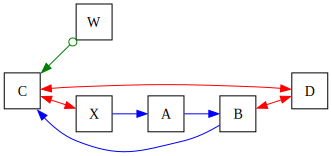

In [160]:
est_pag = learner.graph_
est_pag_no_fnodes = est_pag.subgraph(ctx.get_non_augmented_nodes())
draw(est_pag_no_fnodes, direction="LR")

We see that additional edges can be oriented with the presence of interventional data. Moreover, the SFCI algorithm perfectly 
replicates and builds on top of the interventional data.

Causal Discovery: Observational data across multiple domains
------------------------------------------------------------

In the SFCI paper, it is shown that the $\Psi$-FCI algorithm is equivalent to the SFCI algorithm when there is
observational data across multiple domains, where the F-nodes can be seen as equivalent to S-nodes.

We can leverage the same distributions that were intervened on because the change in domain can be seen
as an unknown-target intervention that occurs over those variables. That is, nature changes the distribution (CPD)
of the intervened variables, but we do not know where nature intervened. Thus conceptually, we see observational
data across multiple domains is similar to the setting with unknown-target interventional data within
a single domain. 

We will see later that when we have interventional data across multiple domains, the story becomes more complex
(and as a result, more interesting).

In [205]:
# create context with information about the interventions
ctx_builder = make_context(create_using=InterventionalContextBuilder)
ctx: Context = (
    ctx_builder.variables(data=data[0])
    .num_distributions(len(data))
    .obs_distribution(True)
    .build()
)

In [238]:
int_learner = PsiFCI(
    ci_estimator=ci_estimator,
    cd_estimator=ci_estimator,
    max_cond_set_size=2,
    n_jobs=-1,
    debug=True,
)

int_learner = int_learner.fit(data, ctx)

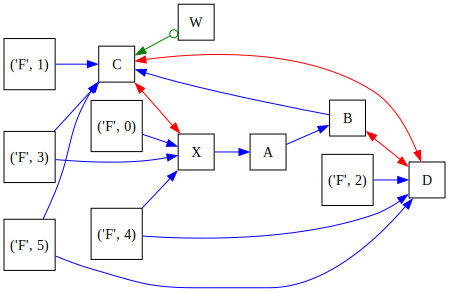

In [240]:
est_pag = int_learner.graph_

# %%
# Visualize the full graph including the F-node
draw(est_pag, direction="LR")

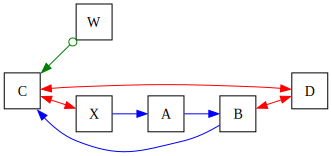

In [242]:
est_pag = int_learner.graph_.subgraph(ctx.get_non_augmented_nodes())

# %%
# Visualize the full graph including the F-node
draw(est_pag, direction="LR")

In [256]:
intervention_targets = [set()] * len(data)
print(intervention_targets)

[set(), set(), set(), set()]


In [268]:
learner = SFCI(
    ci_estimator=ci_estimator,
    cd_estimator=ci_estimator,
    max_cond_set_size=2,
    n_jobs=-1,
    debug=True,
)

learner.fit(
    data,
    ctx,
    domain_indices=[0, 1, 2, 3],
    intervention_targets=intervention_targets,
)

Using data from distribution  0  for learning the skeleton.
Trying to learn skeleton for 0 to remove F-nodes: []
[('S', 0)]
{}
{('S', 0): [0, 1], ('S', 1): [0, 2], ('S', 2): [0, 3], ('S', 3): [1, 2], ('S', 4): [1, 3], ('S', 5): [2, 3]}
here... 


{('S', 2), ('S', 3), ('S', 1), ('S', 4), ('S', 5), ('S', 0)}
0 1
{('S', 0): [0, 1], ('S', 1): [0, 2], ('S', 2): [0, 3], ('S', 3): [1, 2], ('S', 4): [1, 3], ('S', 5): [2, 3]}
{}
Trying to learn skeleton for 0 and 1 to remove S-nodes: [('S', 0)]
Trying to learn skeleton for 0 and 1 to remove F-nodes: [] grouped with S-node: ('S', 0)
[('S', 1)]
{}
{('S', 0): [0, 1], ('S', 1): [0, 2], ('S', 2): [0, 3], ('S', 3): [1, 2], ('S', 4): [1, 3], ('S', 5): [2, 3]}
here... 


{('S', 2), ('S', 3), ('S', 1), ('S', 4), ('S', 5), ('S', 0)}
0 2
{('S', 0): [0, 1], ('S', 1): [0, 2], ('S', 2): [0, 3], ('S', 3): [1, 2], ('S', 4): [1, 3], ('S', 5): [2, 3]}
{}
Trying to learn skeleton for 0 and 2 to remove S-nodes: [('S', 1)]
Trying to learn skeleton for 0 and 2 to re

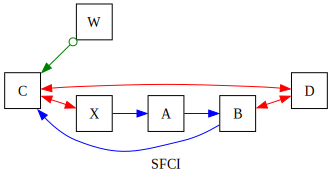

In [272]:
est_pag = learner.graph_
est_pag_no_fnodes = est_pag.subgraph(ctx.get_non_augmented_nodes())
draw(est_pag_no_fnodes, direction="LR", name="SFCI")

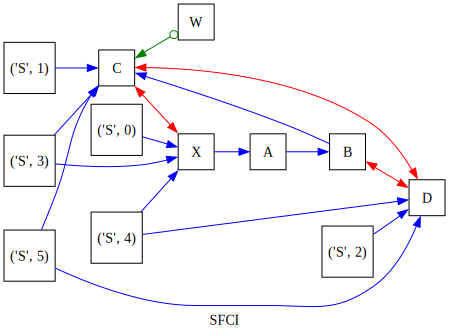

In [273]:
est_pag = learner.graph_
est_pag_no_fnodes = est_pag
dot_graph = draw(
    est_pag_no_fnodes,
    direction="LR",
    # name="SFCI"
)

dot_graph.render(outfile="./sfci_multidomain_obs.png", view=False, cleanup=True)
dot_graph

In [274]:
print(learner.context_.state_variable("node_domain_map"))

{('S', 0): frozenset({0, 1}), ('S', 1): frozenset({0, 2}), ('S', 2): frozenset({0, 3}), ('S', 3): frozenset({1, 2}), ('S', 4): frozenset({1, 3}), ('S', 5): frozenset({2, 3})}


Now, we see that SFCI is equivalent to $\Psi$-FCI in the presence of observational data that spans different domains as shown in the theoretical results of the SFCI paper.
The benefit of explicitly noting the fact that the observational data come from different domains is that we now have knowledge of the S-nodes that underlie the causal
selection diagram. Of course, the S-node edges are simply estimates and moreover it is only part of the Markov equivalence class, since inducing paths may cause extra edges.
However, the information of the S-nodes now provide the user how they should expect distributions and causal knowledge to change when going between different domains.

For example, if we take a look at S-node (S, 2), representing domains 0 and 3, then this induces a potential change in the function, or exogenous variable distribution for variable D. However, because
of the colliders, we see that we could translate causal knowledge between domains 0 and 3 as long as we do not open up a path from (S, 2) node to the rest of the variables.

Causal Discovery: Observational data and interventional data across multiple domains
------------------------------------------------------------------------------------

As we saw in the previous sections, SFCI is capable of exactly producing the same results as the FCI, and I/$\Psi$-FCI algorithms given datasets in a single domain. In addition, when analyzing purely observational data coming from multiple domains, we see an equivalence in the results between SFCI and $\Psi$FCI.

Next, we will show how having both observational and interventional data from different domains can allow us to learn more.

First we will simulate data that comes from multipl domains using a similar procedure.

In [370]:
intervention_targets = targets.copy()
intervention_targets.insert(0, set())
print(intervention_targets)

domain_one_targets = intervention_targets.copy()
domain_two_targets = [set(), "W", "X"]

print(domain_two_targets)

[set(), ['X'], ['C'], ['D']]
[set(), 'W', 'X']


In [371]:
# we will now simulate a set of interventions on the graph
domain_one_data = [df]
for target in domain_one_targets[1:]:
    int_G = apply_discrete_soft_intervention(G.copy(), target, random_state=seed)

    # now we sample from the graph the discrete dataset
    int_df = sample_from_graph(int_G, n_samples=30000, n_jobs=1, random_state=seed)

    domain_one_data.append(int_df)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [372]:
# we will now simulate a set of interventions on the graph
domain_two_data = []
int_G = apply_discrete_soft_intervention(G.copy(), {"X", "C"}, random_state=seed)

# now we sample from the graph the discrete dataset
int_df = sample_from_graph(int_G, n_samples=30000, n_jobs=1, random_state=seed)
domain_two_data.append(int_df)
domain_two_G = int_G.copy()

  0%|          | 0/6 [00:00<?, ?it/s]

In [373]:
# add an S-node to node 'X', starting after the observational "set()"
for target in domain_two_targets[1:]:
    int_G = apply_discrete_soft_intervention(
        domain_two_G.copy(), target, random_state=seed
    )

    # now we sample from the graph the discrete dataset
    int_df = sample_from_graph(int_G, n_samples=30000, n_jobs=1, random_state=seed)

    domain_two_data.append(int_df)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [374]:
data = domain_one_data + domain_two_data
print(len(data))

7


In [375]:
intervention_targets = domain_one_targets + domain_two_targets
print(len(intervention_targets))
print(intervention_targets)

7
[set(), ['X'], ['C'], ['D'], set(), 'W', 'X']


In [376]:
domain_ids = [0] * len(domain_one_targets) + [1] * len(domain_two_targets)
print(len(domain_ids))

7


In [378]:
# create context with information about the interventions
ctx_builder = make_context(create_using=InterventionalContextBuilder)
ctx: Context = ctx_builder.variables(data=data[0]).num_distributions(len(data)).build()

In [382]:
learner = SFCI(
    ci_estimator=ci_estimator,
    cd_estimator=ci_estimator,
    max_cond_set_size=2,
    n_jobs=-1,
    debug=True,
)

learner.fit(
    data,
    ctx,
    domain_indices=domain_ids,
    intervention_targets=intervention_targets,
)

Using data from distribution  0  for learning the skeleton.
Trying to learn skeleton for 0 to remove F-nodes: [('F', 2), ('F', 5), ('F', 0), ('F', 6), ('F', 1), ('F', 10)]
[('S', 0)]
{('F', 0): frozenset({'X'}), ('F', 1): frozenset({'C'}), ('F', 2): frozenset({'D'}), ('F', 3): frozenset({'W'}), ('F', 4): frozenset({'X'}), ('F', 5): frozenset({'X', 'C'}), ('F', 6): frozenset({'X', 'D'}), ('F', 7): frozenset({'X'}), ('F', 8): frozenset({'W', 'X'}), ('F', 9): frozenset(), ('F', 10): frozenset({'D', 'C'}), ('F', 11): frozenset({'C'}), ('F', 12): frozenset({'W', 'C'}), ('F', 13): frozenset({'X', 'C'}), ('F', 14): frozenset({'D'}), ('F', 15): frozenset({'W', 'D'}), ('F', 16): frozenset({'X', 'D'}), ('F', 17): frozenset({'W'}), ('F', 18): frozenset({'X'}), ('F', 19): frozenset({'W', 'X'})}
{('F', 0): [0, 1], ('F', 1): [0, 2], ('F', 2): [0, 3], ('S', 0): [0, 4], ('F', 3): [0, 5], ('F', 4): [0, 6], ('F', 5): [1, 2], ('F', 6): [1, 3], ('F', 7): [1, 4], ('F', 8): [1, 5], ('F', 9): [1, 6], ('F', 1

In [395]:
print(context.init_graph.nodes)
print(est_pag.nodes)
print(ctx.get_non_augmented_nodes())

['W', 'C', 'B', 'A', 'X', 'D']
['W', 'X', 'C', 'B', 'D', 'A', ('F', 2), ('F', 5), ('F', 11), ('F', 8), ('F', 14), ('F', 17), ('F', 0), ('F', 3), ('F', 9), ('F', 6), ('F', 12), ('F', 15), ('F', 18), ('F', 4), ('F', 1), ('F', 7), ('F', 10), ('F', 16), ('F', 13), ('F', 19), ('S', 0)]
{'C', 'B', 'D', 'W', 'X', 'A'}


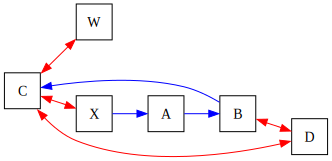

In [400]:
est_pag = learner.graph_
est_pag_no_fnodes = est_pag.subgraph(ctx.get_non_augmented_nodes())

dot_graph = draw(
    est_pag_no_fnodes,
    direction="LR",
    # name="SFCI"
)

dot_graph.render(outfile="./sfci_multidomain_obsandint.png", view=False, cleanup=True)
dot_graph